<a href="https://colab.research.google.com/github/RachmaAyudyaw/MachineLearningDicodingGoogleResearchCollab/blob/main/Proyek2_MembuatModelMachineLearningdDenganDataTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
data=pd.read_csv('AABA_2006-01-01_to_2018-01-01.csv')
data.shape

(3019, 7)

In [ ]:
data

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA
...,...,...,...,...,...,...,...
3014,2017-12-22,71.42,71.87,71.22,71.58,10979165,AABA
3015,2017-12-26,70.94,71.39,69.63,69.86,8542802,AABA
3016,2017-12-27,69.77,70.49,69.69,70.06,6345124,AABA
3017,2017-12-28,70.12,70.32,69.51,69.82,7556877,AABA


In [ ]:
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [ ]:
from sklearn.preprocessing import MinMaxScaler
#values=open.reshape((len(open), 1))
scaler=MinMaxScaler(feature_range=(0,1))
X_scaler=scaler.fit_transform(data[['Open']])
data[['Open']]=X_scaler
data[['Open']]

,Open
0,0.478567
1,0.502503
2,0.497966
3,0.528473
4,0.531915
...,...
3014,0.974969
3015,0.967459
3016,0.949155
3017,0.954631


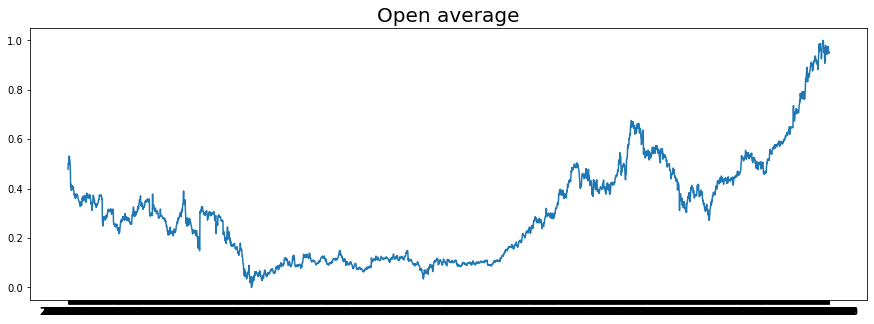

In [ ]:
#dates=data['Date'].values
dates=data['Date'].values
open=data['Open'].values

plt.figure(figsize=(15,5))
plt.plot(dates,open)
plt.title('Open average',fontsize=20);

In [ ]:
y=(data['Open'].max()-data['Open'].min())*0.1
y

6.3919999999999995

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(open, dates, test_size=0.2, shuffle=False, random_state=0)

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(2415,) (604,) (2415,) (604,)


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('mae')<0.1):
      print("\nMae telah mencapai < 10%!")
      self.model.stop_training=True
callbacks=myCallback()

In [ ]:
train_set= windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(60,return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-03,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set,epochs=100,validation_data=test_set,callbacks=[callbacks])

Epoch 1/100
24/24 [==============================] - 9s 160ms/step - loss: 0.0327 - mae: 0.2091 - val_loss: 0.1429 - val_mae: 0.4999
Epoch 2/100
24/24 [==============================] - 3s 122ms/step - loss: 0.0194 - mae: 0.1422 - val_loss: 0.1079 - val_mae: 0.4251
Epoch 3/100
24/24 [==============================] - 3s 121ms/step - loss: 0.0130 - mae: 0.1227 - val_loss: 0.0884 - val_mae: 0.3763
Epoch 4/100
24/24 [==============================] - 3s 124ms/step - loss: 0.0110 - mae: 0.1206 - val_loss: 0.0781 - val_mae: 0.3483
Epoch 5/100
24/24 [==============================] - 3s 121ms/step - loss: 0.0104 - mae: 0.1205 - val_loss: 0.0726 - val_mae: 0.3328
Epoch 6/100
24/24 [==============================] - 3s 122ms/step - loss: 0.0103 - mae: 0.1206 - val_loss: 0.0695 - val_mae: 0.3240
Epoch 7/100
24/24 [==============================] - 3s 125ms/step - loss: 0.0102 - mae: 0.1208 - val_loss: 0.0678 - val_mae: 0.3189
Epoch 8/100
24/24 [==============================] - 3s 123ms/step - 

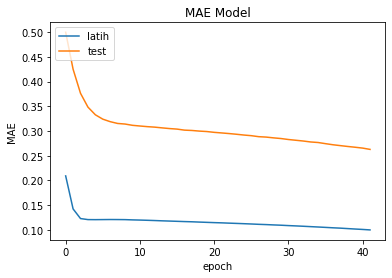

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['latih','test'],loc='upper left')
plt.show()

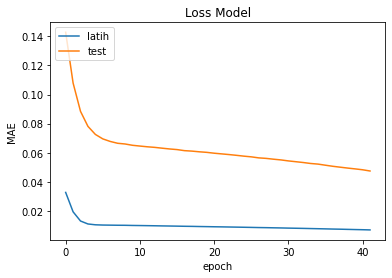

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['latih','test'],loc='upper left')
plt.show()